Naivní implementace SVR pomocí knihovny CVXOPT.

Materiály viz přednáška https://colab.research.google.com/drive/16zKEsucqXlx9s3Tduz_Ubp_8aS15JzxB?usp=drive_link

In [1]:
import numpy as np
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt

In [2]:
def create_model_SVR_primary(X, y, C=10.0, eps=1):
    """generuje matice pro knihovnu CVXOPT pro reseni SVR problemu"""
    m, n = X.shape  # zjisti si rozmery
    # m - pocet bodu
    # n - dimenze
    # generovani matic a vektoru pro ucelovou funkci
    # generovani matice P - pro resic vstupuje jako matice prislusne kvadraticke formy
    P = np.zeros((n + 1 + 2 * m, n + 1 + 2 * m))
    for i in range(0, n):
        P[i, i] = 1  # prepis 1 na diagonalu pro hodnoty w
    # generovani vektoru q - vektor s koeficienty pro linearni cast ucelove funkce
    q = C * np.ones(n + 1 + 2 * m)  # linearni clen v ucelove funkci soucet ksi
    q[:n + 1] = 0  # nastav na nulu pozice w a b ve vektoru q
    # generovani omezujicich podminek
    h = np.concatenate((np.zeros((2 * m, 1)), np.zeros((2 * m, 1))))
    G = np.zeros((4 * m, n + 1 + 2 * m))
    for i, (x, y) in enumerate(zip(X, y)):  # pres vsechny datove body
        # prvni omezeni
        G[i, :n] = x  # sloupce odpovidajici w
        G[i, n] = 1.  # sloupec odpovidajici b
        G[i, n + 1 + i] = -1.  # sloupec ksi+
        h[i] = y + eps
        # druhe omezeni
        G[i + m, :n] = -x  # sloupce odpovidajici w
        G[i + m, n] = -1.  # sloupec odpovidajici b
        G[i + m, n + 1 + i + m] = -1.  # sloupec ksi-
        h[i + m] = -y + eps
        # podminky nezapornosti ksi+
        G[i + 2 * m, n + 1 + i] = -1.
        # podminky nezapornosti ksi-
        G[i + 3 * m, n + 1 + i + m] = -1.

    print(f"P:{P.shape}")
    print(f"q:{q.shape}")
    print(f"G:{G.shape}")
    print(f"h:{h.shape}")
    return matrix(P), matrix(q), matrix(G), matrix(h)

In [3]:
def get_points(n, f=lambda x: 4 * x + 2, a=0, b=10, noise=2):
    x = a + (b - a) * np.random.rand(n)
    y = f(x) + np.random.rand(n) * noise
    return np.array(x).reshape((n, 1)), np.array(y)

# Ukazka pro linearni data

P:(202, 202)
q:(202,)
G:(400, 202)
h:(400, 1)
(202, 202)
     pcost       dcost       gap    pres   dres
 0: -1.0992e+04 -1.0892e+02  7e+03  5e-01  8e-14
 1: -3.9956e+02  8.4049e+02  9e+02  5e-02  8e-15
 2:  1.2272e+03  1.3591e+03  1e+02  7e-03  2e-14
 3:  1.3567e+03  1.4075e+03  7e+01  3e-03  7e-14
 4:  1.4290e+03  1.4387e+03  2e+01  8e-04  4e-14
 5:  1.4473e+03  1.4486e+03  5e+00  2e-04  1e-13
 6:  1.4517e+03  1.4517e+03  1e-01  2e-06  2e-14
 7:  1.4517e+03  1.4517e+03  1e-03  2e-08  5e-15
Optimal solution found.


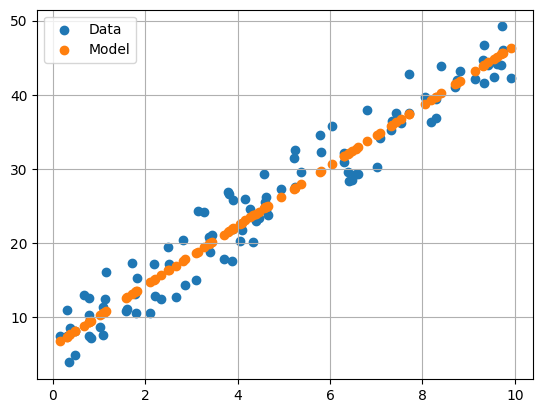

In [4]:
X, y = get_points(100, noise=10)
P, q, G, h = create_model_SVR_primary(X, y)
print(np.array(P).shape)
sol = solvers.qp(P, q, G, h)  # zavolani resice
w = np.array([sol['x'][0]])
b = np.array([sol['x'][1]])
y_hat = (X @ w + b)
plt.scatter(X, y,label="Data")
plt.scatter(X, y_hat, label="Model")
plt.legend()
plt.grid()
plt.show()

#Úloha obsahující nelineární data

Protože používám primární formulaci SVR, tak nepoužívám jádrový trik, ale přímo nelineární transformaci.

(200, 9)
P:(410, 410)
q:(410,)
G:(800, 410)
h:(800, 1)
     pcost       dcost       gap    pres   dres
 0: -2.0020e+08 -1.9914e+05  1e+06  2e+02  1e-04
 1: -3.0860e+07 -8.4988e+04  3e+05  2e+01  1e-01
 2: -4.2671e+06  3.6918e+04  5e+04  3e+00  2e-02
 3: -9.0824e+05  5.8120e+04  1e+04  8e-01  4e-01
 4: -1.2061e+05  6.3853e+04  4e+03  2e-01  2e-01
 5:  3.8602e+04  6.5365e+04  7e+02  2e-02  3e-02
Terminated (singular KKT matrix).


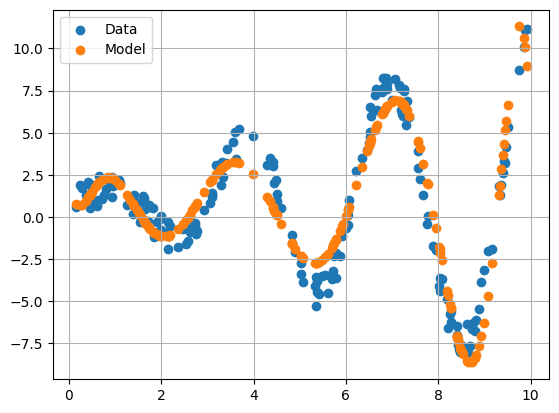

In [5]:
X, y = get_points(200, f=lambda x: x * np.cos(2 * x + 5))  # nelinearni data
# toto je nelinearni transformace - nekernelova, pomoci polynomu
X_tr = np.array([X, X ** 2, X ** 3, X ** 4, X ** 5, X ** 6, X ** 7, X ** 8, X ** 9]).squeeze(axis=2).transpose()
dim = X_tr.shape[1]
print(X_tr.shape)
P, q, G, h = create_model_SVR_primary(X_tr, y, C=1e3)
sol = solvers.qp(P, q, G, h)  # zavolani resice
result = np.array(sol["x"])
w = result[:dim].flatten() # vezmi si vahy z reseni
b = result[dim]
y_hat = (X_tr @ w + b) # spocti linearni kombinaci vah a hodnot X

plt.scatter(X, y, label="Data")
plt.scatter(X, y_hat, label="Model")
plt.legend()
plt.grid()
plt.show()